# **World Model Renders**
---


### Load Trained Models

In [1]:
from models.vision_model import Vision
from utils import CarRacingDataset
import torch
from torch.utils.data import DataLoader
from models.rnn_mdn import MDNRNN, sample_mdn

# Models hiperparameters
mask = 0.03
path = 'trained_models'


# Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dataset = CarRacingDataset('car_racing_data_1024.h5')
# dataloader = DataLoader(dataset,batch_size=128,shuffle=True)


# Vision model
name = f'vision_{int(mask * 100):02d}_miniVAE'
vision = Vision(
        n_features_to_select=mask, in_ch=3,
        out_ch=3, base_ch=16, alpha=1.0, delta=0.1
    ).to(device)

vision.load_state_dict(torch.load(f'{path}/{name}.pth', weights_only=True, map_location=device))
vision.eval()

# RNN-MDN
mdnrnn = MDNRNN(latent_dim=32, action_dim=3, hidden_dim=256, num_gaussians=5).to(device)
mdnrnn.load_state_dict(torch.load(f'{path}/memory.pth', weights_only=True, map_location=device))
mdnrnn.eval()

# Numer of parameters
print(f"Number of parameters: {sum(p.numel() for p in vision.parameters()):,}")

pygame 2.6.1 (SDL 2.28.4, Python 3.11.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Number of parameters: 4,039,089


/home/bruno/anaconda3/envs/world/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
print(f"Number of parameters: {sum(p.numel() for p in vision.downscaling.parameters()):,}")

Number of parameters: 29,124


## **Vision model visualization**
---


### Images Reconstruction

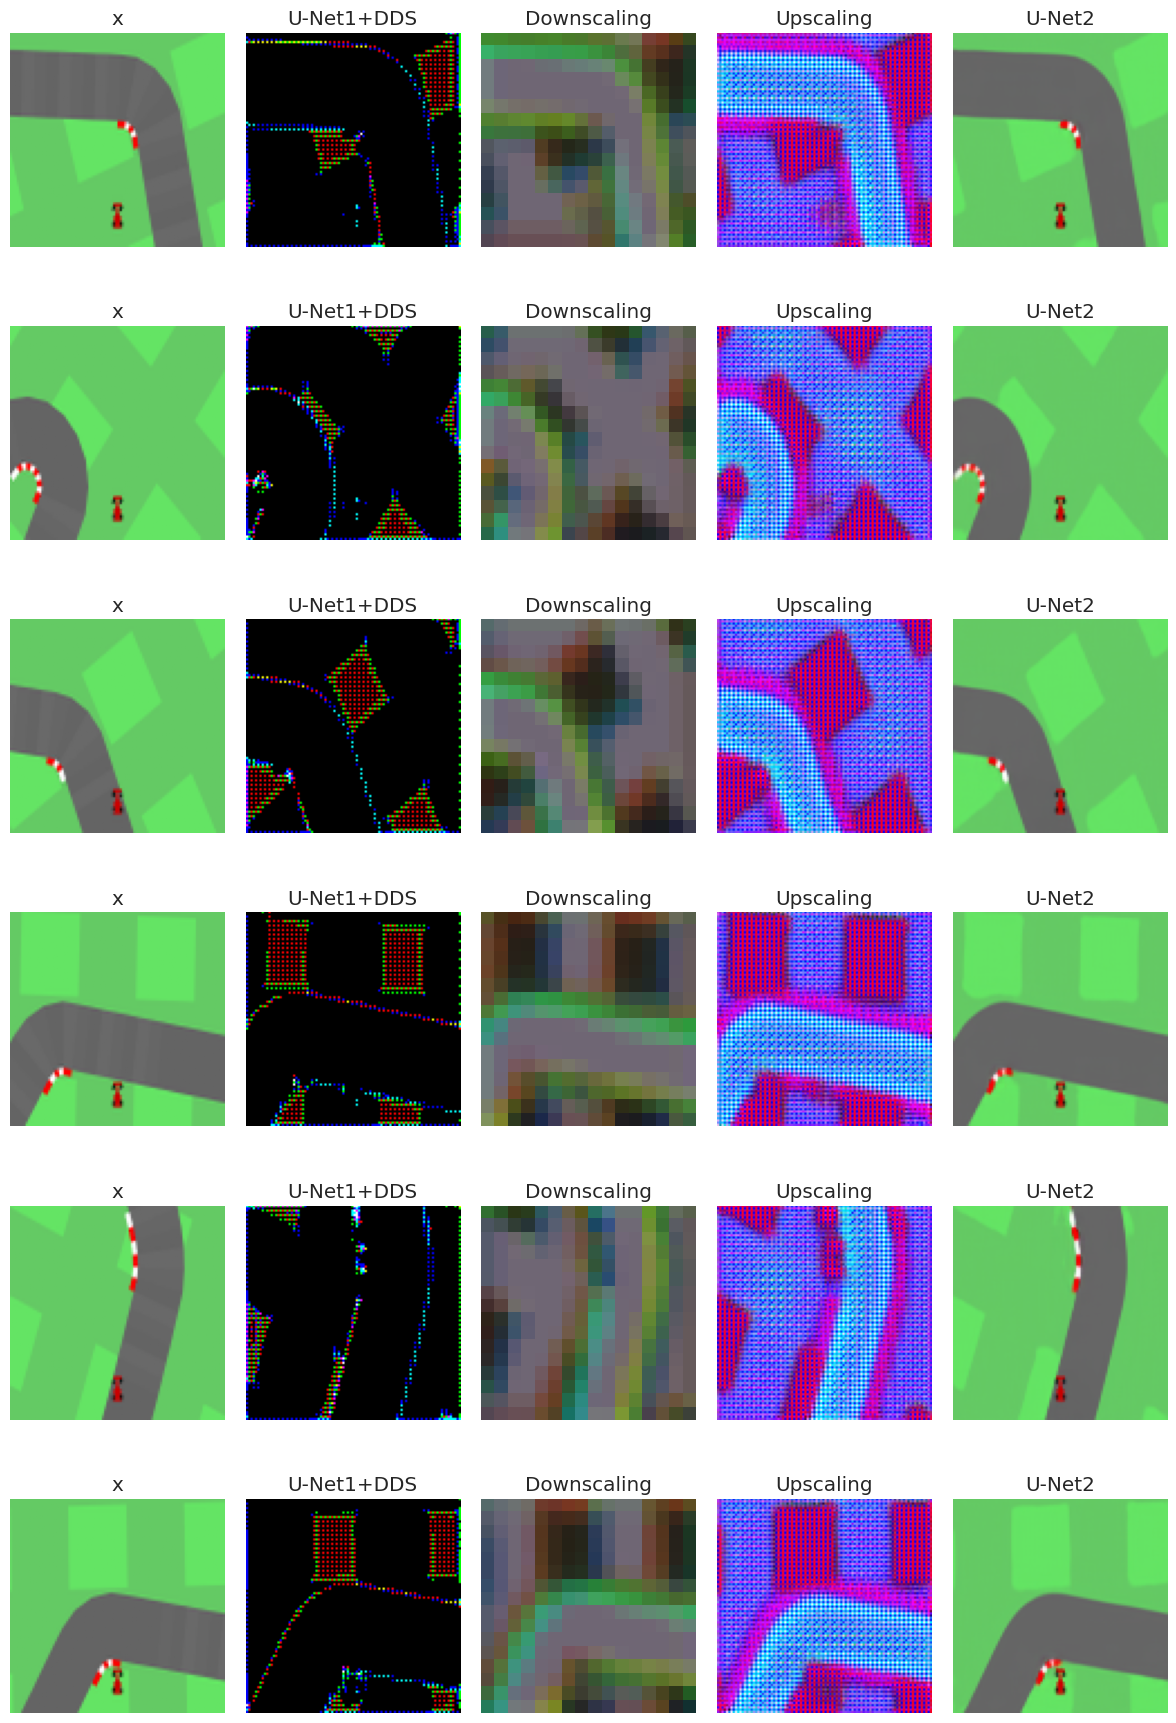

In [48]:
from utils import plot_vision

plot_vision(vision, dataset, device, images=[145, 6952, 970, 1920, 4450, 7400], save_path=f'renders/Vision.png', save=False)

### Play with Vision

In [9]:
import os
import gymnasium as gym
import pygame
import numpy as np
import torch
from torchvision import transforms
import cv2
from utils import ensure_dir_exists, setup_video_writer, reset, get_action, preprocess_image
from utils import TRANSFORM as transform

def run_car_racing(env_name, transform, device, scale=1, resolution=(96, 96), save_video=False, video_filename="car_racing_vision.mp4"):
    """Run the car racing environment with specified settings."""

    # --- Setup Directories and Video Writer ---
    ensure_dir_exists('renders')
    video_filepath = os.path.join('renders', video_filename)

    pygame.init()
    display_resolution = (resolution[0] * 4 * scale, resolution[1] * scale)
    screen = pygame.display.set_mode(display_resolution)
    clock = pygame.time.Clock()
    font = pygame.font.Font(None, 36)

    video_writer = setup_video_writer(video_filepath, display_resolution[::-1]) if save_video else None

    # --- Initialize Environment ---
    env = gym.make(env_name, render_mode='rgb_array')
    obs = reset(env)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # --- Handle Actions ---
        keys = pygame.key.get_pressed()
        action = get_action(keys)
        obs, reward, done, info, _ = env.step(action)

        # --- Transform and Process Observation ---
        x = transform(obs).unsqueeze(0).to(device)

        with torch.no_grad():
            mini_mask, mask, binary_mask = vision.downscale(x)
            x_hat, mask_hat = vision.upscale(mini_mask)

        mse = torch.mean((x - x_hat) ** 2).item()

        images = [x, mask, mini_mask, x_hat]
        processed_images = [preprocess_image(img, resolution) for img in images]
        full_image = np.concatenate(processed_images, axis=0)
        full_image_resized = cv2.resize(full_image, (display_resolution[1], display_resolution[0]), interpolation=cv2.INTER_LINEAR)

        # --- Render and Display ---
        pygame.surfarray.blit_array(screen, full_image_resized)
        mse_text = font.render(f"MSE: {mse:.5f}", True, (255, 255, 255))
        screen.blit(mse_text, (10, 10))
        pygame.display.flip()

        if save_video and video_writer is not None:
            video_writer.write(cv2.cvtColor(full_image_resized, cv2.COLOR_RGB2BGR))

        clock.tick(30)
        if done:
            obs = reset(env)

    # --- Cleanup ---
    if save_video and video_writer is not None:
        video_writer.release()

    pygame.quit()
    env.close()

# --- Main Execution ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_car_racing(env_name="CarRacing-v3", transform=transform, device=device, scale=5, save_video=True)


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


### **miniVAE Visualization**
---

### Latent Space Distribution

Extracting latent space: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


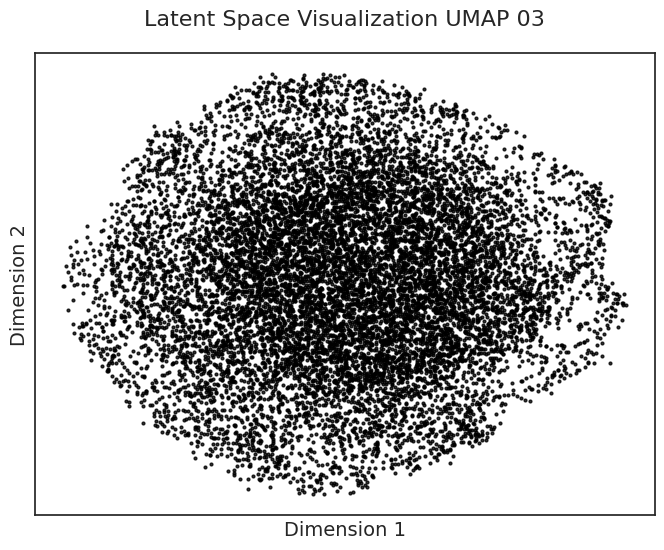

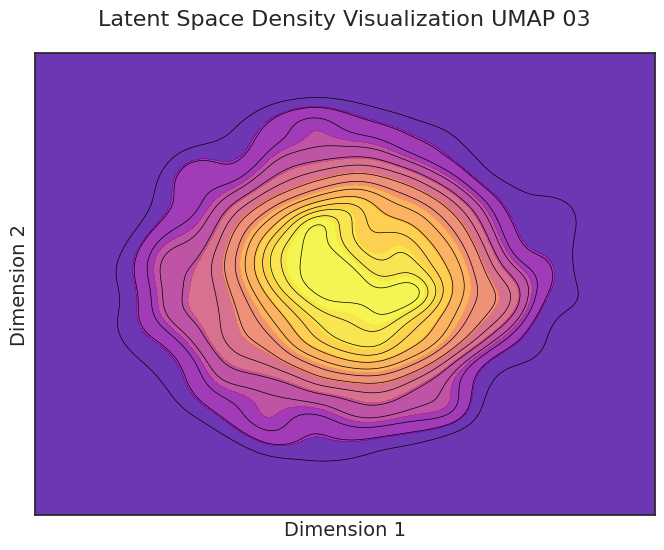

In [39]:
from tqdm import tqdm
import umap.umap_ as umap
from utils import (
    CarRacingDataset,
    plot_latent_space,
    plot_latent_space_density,
    get_latent_space
)

latent_space = get_latent_space(vision, dataloader, latent_size=32, max_batch=100)

umap_model = umap.UMAP(n_components=2, min_dist=0.5)
latent_2d_umap = umap_model.fit_transform(latent_space)

plot_latent_space(latent_2d_umap, '', f'UMAP {int(mask * 100):02d}', save = False)
plot_latent_space_density(latent_2d_umap, '', f'UMAP {int(mask * 100):02d}', save=False)

### miniVAE image reconstruction

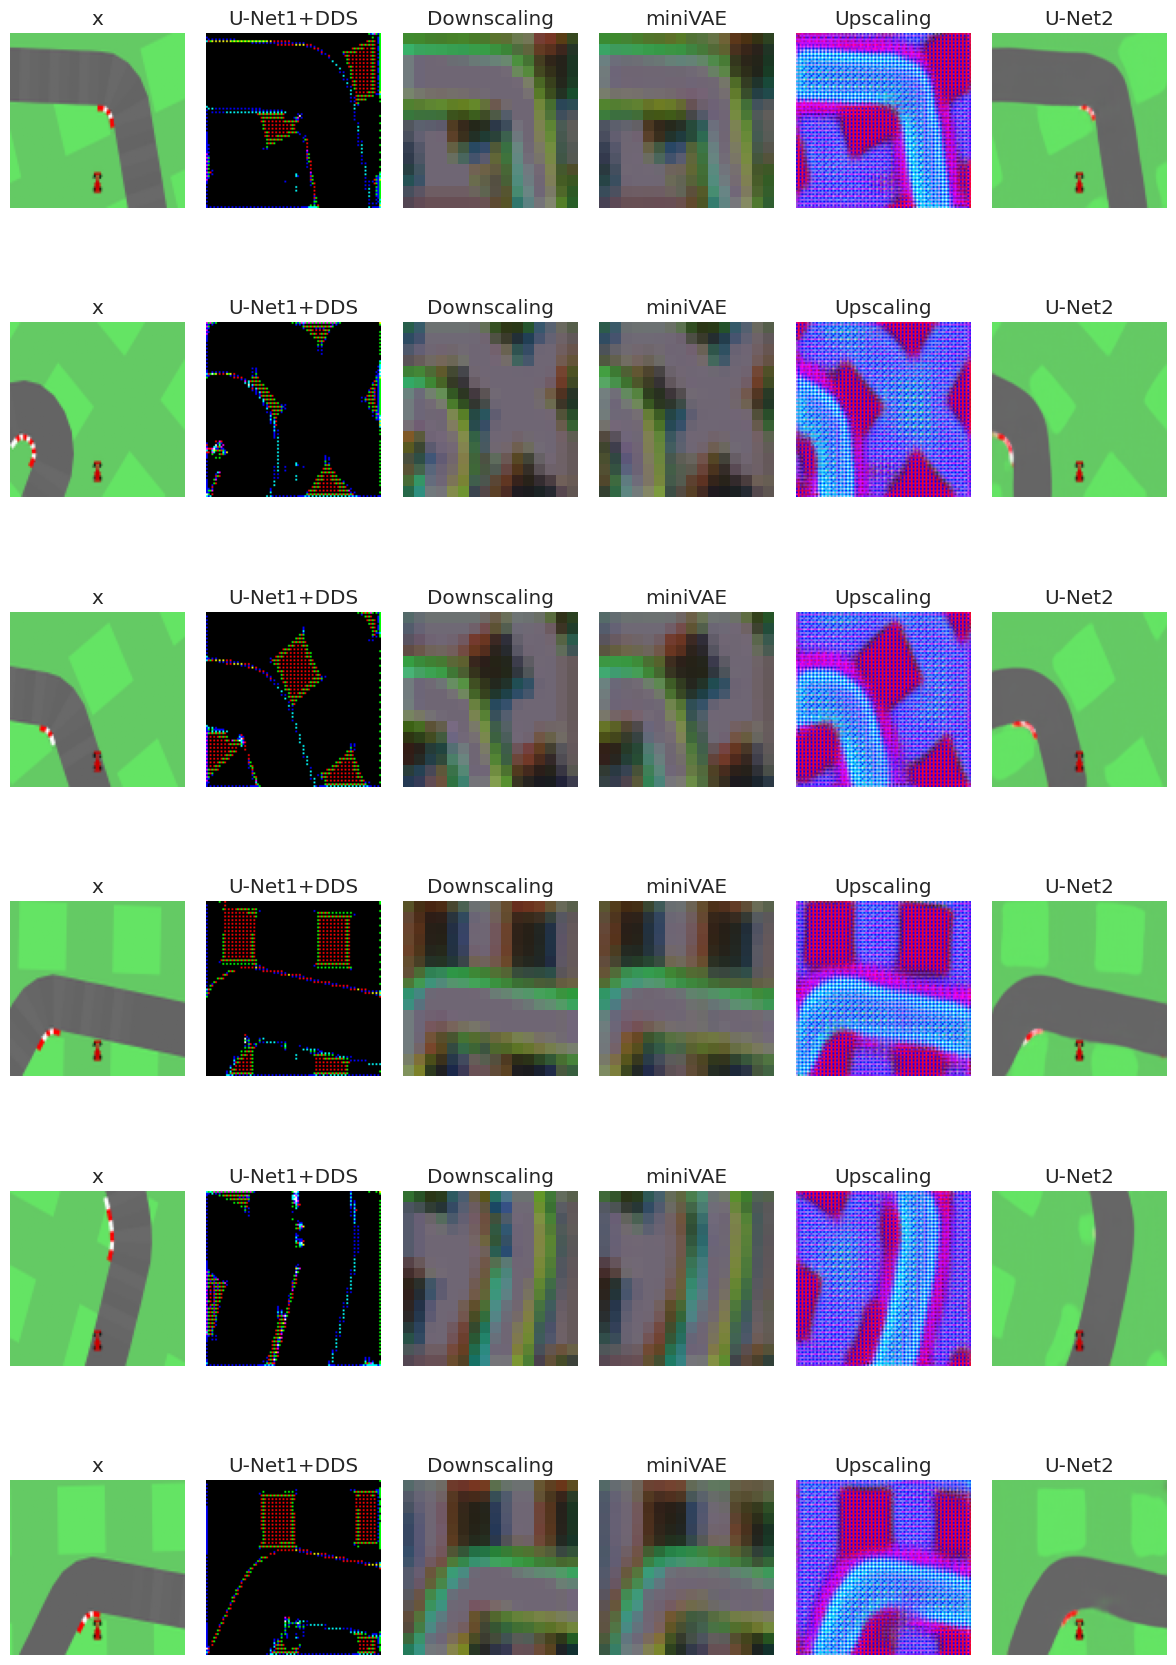

In [45]:
from utils import plot_mini_vae

plot_mini_vae(vision, dataset, device, save_path='renders/mini_vae.png', images=[145, 6952, 970, 1920, 4450, 7400], save=False)

### Latent Space Exploration

In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, VBox, Button, Output, HBox, IntSlider
import torch
import cv2

LATENT_SIZE = 32
SHIFT = 0  # Initial SHIFT value
def generate_image(latent_vector):
    """ Generate an image from a latent vector using the VAE model. """
    device = next(vision.parameters()).device
    with torch.no_grad():
        latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)

        x_hat, _, _ = vision.decode(latent_tensor)

        generated_image = x_hat.squeeze(0).permute(1,2,0).cpu().numpy()
        return generated_image

# Create sliders for latent space dimensions
num_sliders = 8
sliders = [FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description=f'Latent {i+1}') for i in range(num_sliders)]

output = Output()

def update_image(change):
    """
    Update the displayed image based on the current slider values.
    """
    latent_vector = np.zeros(LATENT_SIZE)
    for i, slider in enumerate(sliders):
        latent_vector[i + shift_slider.value] = slider.value
    generated_image = generate_image(latent_vector)
    
    with output:
        output.clear_output(wait=True)
        plt.figure(figsize=(5, 5))
        plt.imshow(generated_image)  # Adjust dimensions if necessary
        plt.axis('off')  # Hide axes
        plt.title('Generated Image')
        plt.show()

def update_slider_labels(shift_value):
    """
    Update slider labels based on the shift value.
    """
    for i, slider in enumerate(sliders):
        slider.description = f'Latent {i + 1 + shift_value}'

# Link sliders to update function
for slider in sliders:
    slider.observe(update_image, 'value')

def generate_random_latent(button):
    """
    Generate a random latent vector and update sliders.
    """
    latent_vector = np.random.uniform(-3.0, 3.0, size=LATENT_SIZE)
    for i, slider in enumerate(sliders):
        slider.value = latent_vector[i + shift_slider.value]
    update_image(None)

# Create buttons
random_button = Button(description='Generate Random Latent Vector')
random_button.on_click(generate_random_latent)

reset_button = Button(description='Reset Sliders')
def reset_sliders(button):
    """
    Reset all sliders to zero.
    """
    for slider in sliders:
        slider.value = 0.0
    update_image(None)
reset_button.on_click(reset_sliders)

# Shift slider to adjust which latent dimensions the other sliders modify
shift_slider = IntSlider(value=0, min=0, max=LATENT_SIZE - num_sliders, step=1, description='SHIFT')
shift_slider.observe(lambda change: update_slider_labels(shift_slider.value), 'value')  # Update slider labels on shift change
shift_slider.observe(update_image, 'value')

# Create a vertical box for sliders, shift slider, and buttons with padding
slider_box = VBox(sliders + [shift_slider, random_button, reset_button], layout={'margin': '30px 0 0 0'})  # Add top margin

# Create a horizontal box to hold the image output and sliders
layout = HBox([output, slider_box])

# Display the layout
display(layout)

# Generate an initial image and set initial slider labels
update_slider_labels(shift_slider.value)
update_image(None)


### Play with miniVAE

In [59]:
from torchvision import transforms
import os
import pygame
import gymnasium as gym
import numpy as np
import cv2
from utils import ensure_dir_exists, setup_video_writer, reset, get_action, preprocess_image
from utils import TRANSFORM as transform    

def run_car_racing(env_name, transform, device, scale=1, resolution=(96, 96), save_video=False, video_filename="car_racing_miniVAE.mp4"):
    """Run the car racing environment with specified settings."""

    # --- Setup Directories and Video Writer ---
    ensure_dir_exists('renders')
    video_filepath = os.path.join('renders', video_filename)

    pygame.init()
    display_resolution = (resolution[0] * 4 * scale, resolution[1] * scale)
    screen = pygame.display.set_mode(display_resolution)
    clock = pygame.time.Clock()
    font = pygame.font.Font(None, 36)

    video_writer = setup_video_writer(video_filepath, display_resolution[::-1]) if save_video else None

    # --- Initialize Environment ---
    env = gym.make(env_name, render_mode='rgb_array')
    obs = reset(env)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # --- Handle Actions ---
        keys = pygame.key.get_pressed()
        action = get_action(keys)
        obs, reward, done, info, _ = env.step(action)

        # --- Transform and Process Observation ---
        x = transform(obs).unsqueeze(0).to(device)

        with torch.no_grad():
            mask, mini_mask, z = vision.encode_eval(x)
            x_hat, mask_hat, mini_mask_hat = vision.decode(z)

        mse = torch.mean((mini_mask - mini_mask_hat) ** 2).item()

        images = [x, mini_mask, mini_mask_hat, x_hat]
        processed_images = [preprocess_image(img, resolution) for img in images]
        full_image = np.concatenate(processed_images, axis=0)
        full_image_resized = cv2.resize(full_image, (display_resolution[1], display_resolution[0]), interpolation=cv2.INTER_LINEAR)

        # --- Render and Display ---
        pygame.surfarray.blit_array(screen, full_image_resized)
        mse_text = font.render(f"MSE: {mse:.5f}", True, (255, 255, 255))
        screen.blit(mse_text, (10, 10))
        pygame.display.flip()

        if save_video and video_writer is not None:
            video_writer.write(cv2.cvtColor(full_image_resized, cv2.COLOR_RGB2BGR))

        clock.tick(30)
        if done:
            obs = reset(env)

    # --- Cleanup ---
    if save_video and video_writer is not None:
        video_writer.release()

    pygame.quit()
    env.close()

# --- Main Execution ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_car_racing(env_name="CarRacing-v3", transform=transform, device=device, scale=5, save_video=True)


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# **RNN-MDA**
---

In [3]:
import gymnasium as gym
import pygame
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
import cv2
from utils import TRANSFORM as transform

def run_car_racing_rnn_mda(env_name, vision, mdnrnn, transform, device, scale=1, resolution=(150, 150), tau =1.0):
    
    # Initialize pygame for rendering
    pygame.init()
    resolution = (resolution[0] * 2 * scale, resolution[1] * scale)
    screen = pygame.display.set_mode(resolution)
    clock = pygame.time.Clock() 
    
    action = np.zeros(3)  # Initialize action array
    
    def get_action(keys):
        """ Map keyboard input to actions """
        action[0] = -1.0 if keys[pygame.K_LEFT] else 1.0 if keys[pygame.K_RIGHT] else 0.0  # Steering
        action[1] = 1.0 if keys[pygame.K_UP] else 0.0  # Accelerate
        action[2] = 1.0 if keys[pygame.K_DOWN] else 0.0  # Brake
        return action
    
    
    # Initialize the environment
    env = gym.make(env_name, render_mode='rgb_array')
    obs, _ = env.reset()
    
    running = True
    h = mdnrnn.rnn.init_hidden(1) 
    h = (h[0].to(device), h[1].to(device))
    
    cnt = 0
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        
        keys = pygame.key.get_pressed()  # Get current key states
        action = get_action(keys)        # Update action based on key presses

        # Enviroment step 
        obs, reward, done, info, _ = env.step(action)
        
        # Render and process the frame
        x = transform(obs).unsqueeze(0).to(device)  # Transform frame to tensor

        with torch.no_grad():
            mask, mini_mask, z = vision.encode(x)           
                
            # Generate predicted next image  using RNN-MDA
            action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            pi, mu, sigma, h = mdnrnn(z.unsqueeze(0),action_tensor, h=h, tau=tau)
            z_next = sample_mdn(pi, mu, sigma)
            
            # Decode MDN sampled latent vector
            x_hat, mask_hat, mini_mask_hat =  vision.decode(z_next.squeeze(0))
            reconstructed = x_hat

        cnt+=1
        
        # Prepare images for display
        reconstructed = (reconstructed.squeeze(0).permute(2, 1, 0).cpu().numpy() * 255).astype(np.uint8)
        obs = (x.squeeze(0).permute(2, 1, 0).cpu().numpy() * 255).astype(np.uint8)
        
        # Concatenate original and reconstructed images
        full_image = np.concatenate((obs, reconstructed), axis=0)
        full_image_resized = cv2.resize(full_image, (resolution[1], resolution[0]), interpolation=cv2.INTER_LINEAR)
        
        # Display the combined image
        clock.tick(30)
        pygame.surfarray.blit_array(screen, full_image_resized)
        pygame.display.flip()
        
        if done:
            obs, _ = env.reset()  # Reset environment if done
            h = mdnrnn.rnn.init_hidden(1) 
            h = (h[0].to(device), h[1].to(device))
            
    pygame.quit()
    env.close()
# 

run_car_racing_rnn_mda(env_name="CarRacing-v3", vision=vision, mdnrnn=mdnrnn, transform=transform, device=device, scale=4, tau=0.1)


In [2]:
import gymnasium as gym
import pygame
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from utils import TRANSFORM as transform
from utils import setup_video_writer

def run_car_racing_rnn_mda(env_name, vision, mdnrnn, transform, device, scale=1, resolution=(150, 150), tau=1.0, video_filepath='renders/dream.mp4', save_video=False):
    import pygame
    import numpy as np
    import torch
    import cv2

    # Initialize the environment
    env = gym.make(env_name, render_mode='rgb_array')
    obs, _ = env.reset()
    for _ in range(0):
        env.step(np.array([0, 0, 0]))

    # Initialize pygame for rendering
    pygame.init()
    resolution = (resolution[0] * scale, resolution[1] * scale)
    screen = pygame.display.set_mode(resolution)
    clock = pygame.time.Clock()

    action = np.zeros(3)  # Initialize action array
    video_writer = setup_video_writer(video_filepath, resolution[::-1]) if save_video else None

    def get_action(keys):
        """ Map keyboard input to actions """
        action[0] = -1.0 if keys[pygame.K_LEFT] else 1.0 if keys[pygame.K_RIGHT] else 0.0  # Steering
        action[1] = 1.0 if keys[pygame.K_UP] else 0.0  # Accelerate
        action[2] = 1.0 if keys[pygame.K_DOWN] else 0.0  # Brake
        return action

    running = True
    h = mdnrnn.rnn.init_hidden(1)
    h = (h[0].to(device), h[1].to(device))

    cnt = 0
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        keys = pygame.key.get_pressed()  # Get current key states
        action = get_action(keys)  # Update action based on key presses

        # Environment step
        obs, reward, done, info, _ = env.step(action)
        obs_tensor = transform(obs).unsqueeze(0).to(device)  # Transform frame to tensor

        with torch.no_grad():
            if cnt == 0:
                mask, mini_mask, z = vision.encode(obs_tensor)
                z = z.unsqueeze(0)
            else:
                z = z_next

            action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            pi, mu, sigma, h = mdnrnn(z, action_tensor, h=h, tau=tau)
            z_next = sample_mdn(pi, mu, sigma)

            x_hat, mask_hat, mini_mask_hat = vision.decode(z_next.squeeze(0))
            reconstructed = x_hat

        cnt += 1

        # Prepare the reconstructed image for display
        reconstructed = (reconstructed.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        reconstructed_resized = cv2.resize(reconstructed, (resolution[0], resolution[1]))

        # Convert reconstructed image to pygame surface
        frame_surface = pygame.surfarray.make_surface(reconstructed_resized.swapaxes(0, 1))

        # Blit frame to the screen
        screen.blit(frame_surface, (0, 0))

        # Draw key indicators using pygame shapes
        indicator_color = (255, 0, 0)  # Red color for indicators

        # Left arrow (proportional size)
        if keys[pygame.K_LEFT]:
            pygame.draw.polygon(screen, indicator_color, [(40, resolution[1] - 40), (20, resolution[1] - 30), (40, resolution[1] - 20)])

        # Right arrow (proportional size)
        if keys[pygame.K_RIGHT]:
            pygame.draw.polygon(screen, indicator_color, [(100, resolution[1] - 40), (120, resolution[1] - 30), (100, resolution[1] - 20)])

        # Up arrow (centered and proportional)
        if keys[pygame.K_UP]:
            pygame.draw.polygon(screen, indicator_color, [(70, resolution[1] - 70), (50, resolution[1] - 50), (90, resolution[1] - 50)])

        # Down arrow (proportional rectangle)
        if keys[pygame.K_DOWN]:
            pygame.draw.rect(screen, indicator_color, (140, resolution[1] - 60, 40, 40))

        # Update the display
        clock.tick(30)
        pygame.display.flip()

        if save_video and video_writer is not None:
            video_writer.write(cv2.cvtColor(reconstructed_resized, cv2.COLOR_RGB2BGR))

        if done:
            obs = env.reset()
            h = mdnrnn.rnn.init_hidden(1)
            h = (h[0].to(device), h[1].to(device))

    pygame.quit()
    env.close()

    if save_video and video_writer is not None:
        video_writer.release()


run_car_racing_rnn_mda(env_name="CarRacing-v3", vision=vision, mdnrnn=mdnrnn, transform=transform, device=device, scale=4, tau=.01, save_video=True)

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

: 

# **Controller**
---

In [2]:
from models.controller import Controller
import gymnasium as gym
import numpy as np
import torch.nn.functional as F

HIDDEN_DIM = 256
LATENT_SIZE = 32

controller = Controller(state_dim=HIDDEN_DIM+LATENT_SIZE, action_dim=3).to(device)
controller.load_state_dict(torch.load(f'trained_models/controller.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [3]:
def encode_obs_batch(vision, obs_batch, size=(96, 96), device='cuda'):
    """Preprocess obs and encode to latent z."""
    obs_tensor = torch.as_tensor(obs_batch, dtype=torch.float32, device=device)
    obs_tensor = obs_tensor.permute(0, 3, 1, 2) / 255.0
    obs_tensor = obs_tensor[:, :, :-12, :]                  
    obs_tensor = F.interpolate(obs_tensor, size=size, mode='bilinear')
    with torch.no_grad():
        _,_, z = vision.encode(obs_tensor)
    return z

def render_policy(env_name, vision, controller, mdnrnn, encode_obs_batch):
    """Render a single policy in a gym environment."""
    env = gym.make(env_name, render_mode='human', lap_complete_percent=1.0)
    done = False
    obs, _ = env.reset()
    
    h = (torch.zeros(1, HIDDEN_DIM).to(device), torch.zeros(1, HIDDEN_DIM).to(device))
    
    cumulative_reward, cnt = 0, 1
    while True:
        z = encode_obs_batch(vision, obs[np.newaxis, ...])
        x = torch.cat([z, h[0]], dim=-1)
        a = controller.get_action(x)
        obs, reward, done, _, _ = env.step(a.detach().cpu().numpy())
        env.render()

        _, h = mdnrnn.rnn(z, a.unsqueeze(0), h=h)
        cumulative_reward += reward
        cnt += 1
        
        if done or cnt >= 1000:
            break
    env.close()
    print(f'Reward: {cumulative_reward} | Steps: {cnt}')



render_policy('CarRacing-v3', vision, controller, mdnrnn, encode_obs_batch)

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
from train_controller import final_evaluaion, parameters_to_vector

controller_best_solution = parameters_to_vector(controller.parameters()).cpu().detach().numpy()

rewards = final_evaluaion(
        vision, Controller, 
        controller_best_solution, mdnrnn, 
        parallel_rollouts=16, max_steps=1000, popsize=16
    )